# Data Filter

The Sentinel NDVI time series data have an unexpected amount of outliers that have to be manually removed before being used as input to the models, for this we will perform some experiments on the data. The first part consists of the implementation of the Local Outlier Factor (an unsupervised outlier identifier), while the second part is the implementation of the Savitzky-Golay and Locally Weighted Scatterplot Smoothing polynomial filters.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
import numpy as np
import pathlib
import operator
import os
from statsmodels.nonparametric.smoothers_lowess import lowess

from typing import Union, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter

In [2]:
# TODO: Changes these values for parameters on a database.
BASE_DIR = '/home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data'
bands =  ['B4','B3','B2','B8']

# Dict of the images.
images = utils.load_landsat_image(BASE_DIR, bands)

Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220409T170849_20220409T171854_T14SPH_09Apr2022_B4.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220409T170849_20220409T171854_T14SPH_09Apr2022_B3.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220409T170849_20220409T171854_T14SPH_09Apr2022_B2.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20220409T170849_20220409T171854_T14SPH_09Apr2022_B8.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S-HARMONIZED_20221019T172329_20221019T172904_T14SPH_19Oct2022_B4.tif
Opening file /home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas22Data/S

In [3]:
days, dates = utils.dates_to_day_numbers(images.keys())

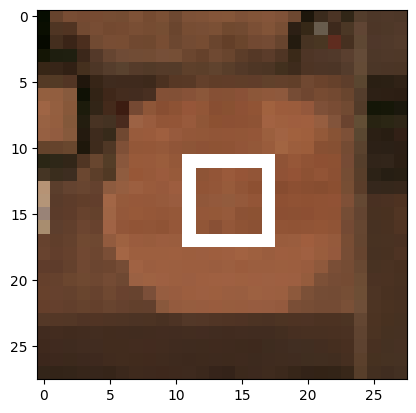

In [4]:
ndvi_series = utils.generate_ndvi_time_series(images)

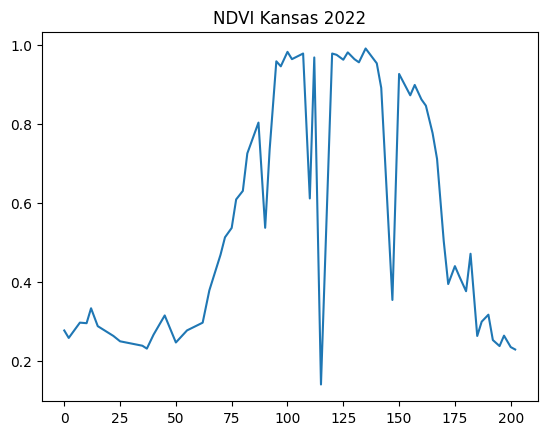

In [5]:
plt.plot(days, ndvi_series)
plt.title('NDVI Kansas 2022')
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest
from operator import itemgetter


def match_indexes(
    indexes: Union[List, None],
    array_to_match: Union[List, None]
) -> List:
    """
    To match an index list to it's reference.
    """
    try:
        intersection = itemgetter(*indexes)(array_to_match)
    except TypeError:
        intersection = []

    # Cast to list.
    if type(intersection) == tuple:
        intersection = list(intersection)
    elif type(intersection) == np.int64:
        intersection = [intersection]

    return intersection


def identify_outliers(
    raw_data: Union[List, np.array],
    outliers_fraction : float = 0.10
) -> List:
    """ Identify an Isolation Forest for outiler identification """
    if raw_data != np.ndarray:
        # Cast and reshape.
        reshaped_data = np.array(raw_data).reshape(-1, 1)
    else:
        reshaped_data = raw_data.reshape(-1, 1)
    
    # Instance the Isolation Forest.
    outliers_model = IsolationForest(
        contamination=outliers_fraction
    )

    # Fit - predict the raw data.
    new_data = outliers_model.fit_predict(
        reshaped_data
    )
    # Get the indexes of the outliers.
    outlier_index = [index for index, value in enumerate(new_data) if value == -1]
    outlier_values = match_indexes(outlier_index, ndvi_series)
    # outlier_values = itemgetter(*outlier_index)(ndvi_series)
    
    # Get the indexes of the good values.
    good_index = [index for index, value in enumerate(new_data) if value == 1]
    good_values = match_indexes(good_index, ndvi_series)
    # good_values = itemgetter(*good_index)(ndvi_series)

    return good_index, good_values, outlier_values, outlier_index


def preprocess_data(
    raw_x : Union[List, np.ndarray],
    raw_y : Union[List, np.ndarray],
    smoothing_filter : str = 'lowess',
    return_outliers : bool = False
) -> Tuple[List]:
    """
    Preprocess the raw data, applying an Unsupervised Outlier Detection and an Smoothing Filter.
    """
    # Get the outliers.
    values, index_values, outliers, out_index = identify_outliers(raw_data=raw_y)

    # Get the x-axis values.
    smoothered_x = match_indexes(index_values, raw_x)

    if return_outliers:
        outlier_indexes = match_indexes(out_index, raw_x)    
        yield outliers, outlier_indexes
    
    # Smooth the curve.
    if smoothing_filter == 'savitzky':
        # Savitzky-Golay polynomial smoothering.
        smoothered_y = savgol_filter(values, window_length=7, polyorder=3)    
    elif smoothing_filter == 'lowess':
        # Locally Weighted Scatterplot Smoothing
        smoothered_y =  lowess(
            values, smoothered_x, is_sorted=False, frac=0.15, it=0, return_sorted=False
        )
    return smoothered_x, smoothered_y


In [ ]:
x, y = preprocess_data(days, ndvi_series)

In [ ]:
# plot data
plt.plot(days, ndvi_series, 'b')
plt.show()